# Libraries 

In [1]:
import pandas as pd
pd.set_option('display.max_columns',None)
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(18,8)},style='darkgrid')
sns.set_palette('rocket')
from time import time
import pingouin
from scipy.stats import ttest_ind
from datasist.structdata import detect_outliers
from geopy.distance import great_circle
from category_encoders import WOEEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

# Collect Data

In [2]:
train = pd.read_csv(r"E:\Data Science\Datasets\Credit Card Fraud Detection\fraudTrain.csv")
train.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [3]:
test = pd.read_csv(r"E:\Data Science\Datasets\Credit Card Fraud Detection\fraudTest.csv")
test.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [4]:
#The test data also contains is_fraud it's not separated to test our model
#So we will concat. them togther to clean them, then make our predictions on test data without is_fraud

In [5]:
train['split'] = 'train'
test['split']='test'
df = pd.concat([train,test],axis=0).reset_index(drop=True)
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,split
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,train
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,train
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,train
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,train
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,train


# Data Preprocessing

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 1852394 entries, 0 to 1852393

Data columns (total 24 columns):

 #   Column                 Dtype  

---  ------                 -----  

 0   Unnamed: 0             int64  

 1   trans_date_trans_time  object 

 2   cc_num                 int64  

 3   merchant               object 

 4   category               object 

 5   amt                    float64

 6   first                  object 

 7   last                   object 

 8   gender                 object 

 9   street                 object 

 10  city                   object 

 11  state                  object 

 12  zip                    int64  

 13  lat                    float64

 14  long                   float64

 15  city_pop               int64  

 16  job                    object 

 17  dob                    object 

 18  trans_num              object 

 19  unix_time              int64  

 20  merch_lat              float64

 21  merch_long             float

In [7]:
#Check Nulls
df.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
split                    0
dtype: int64

In [8]:
df.duplicated().sum()

0

In [9]:
#We found no duplicated rows, so each row is a unique transaction
df.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'split'],
      dtype='object')

In [10]:
#Drop unnecessary columns
#We will drop lcoation of customer as we will get the distance between
#Merchant and customer location later
df.drop(columns=['Unnamed: 0','street','state','first','last','trans_num','unix_time'],inplace=True)

In [11]:
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,gender,city,zip,lat,long,city_pop,job,dob,merch_lat,merch_long,is_fraud,split
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,Moravian Falls,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,36.011293,-82.048315,0,train
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,Orient,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,49.159047,-118.186462,0,train
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,M,Malad City,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,43.150704,-112.154481,0,train
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,Boulder,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,47.034331,-112.561071,0,train
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,M,Doe Hill,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,38.674999,-78.632459,0,train


In [12]:
#Change date type
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'],format='mixed')

In [13]:
df['hour'] = df['trans_date_trans_time'].dt.hour
df['day'] = df['trans_date_trans_time'].dt.day_name()
df['month'] = df['trans_date_trans_time'].dt.month

In [14]:
#clean merchant column
df['merchant'] = df['merchant'].apply(lambda x : x.replace('fraud_',''))

In [15]:
df[['merchant']].head()

,merchant
0,"Rippin, Kub and Mann"
1,"Heller, Gutmann and Zieme"
2,Lind-Buckridge
3,"Kutch, Hermiston and Farrell"
4,Keeling-Crist


In [16]:
#Date of birth --> Age of customer
df['dob'] = pd.to_datetime(df['dob'],format='mixed')
df['age'] = (df['trans_date_trans_time'].dt.year - df['dob'].dt.year).astype(int)
df.drop(columns='dob',inplace=True)

In [17]:
#Location between customer home and merchant
df['distance_km'] = df.apply(lambda col : round(great_circle((col['lat'],col['long']),
                                         (col['merch_lat'],col['merch_long'])).kilometers,2),axis=1)

In [18]:
df.drop(columns=['lat','long','merch_lat','merch_long'],inplace=True)

In [19]:
df.head(2)

,trans_date_trans_time,cc_num,merchant,category,amt,gender,city,zip,city_pop,job,is_fraud,split,hour,day,month,age,distance_km
0,2019-01-01 00:00:18,2703186189652095,"Rippin, Kub and Mann",misc_net,4.97,F,Moravian Falls,28654,3495,"Psychologist, counselling",0,train,0,Tuesday,1,31,78.60
1,2019-01-01 00:00:44,630423337322,"Heller, Gutmann and Zieme",grocery_pos,107.23,F,Orient,99160,149,Special educational needs teacher,0,train,0,Tuesday,1,41,30.21


# EDA

In [20]:
#Summary stats
df.describe().T

,count,mean,min,25%,50%,75%,max,std
trans_date_trans_time,1852394,2020-01-20 21:31:46.801827328,2019-01-01 00:00:18,2019-07-23 04:13:43.750000128,2020-01-02 01:15:31,2020-07-23 12:11:25.249999872,2020-12-31 23:59:34,NaN
cc_num,1852394.0,417386038393710400.0,60416207185.0,180042946491150.0,3521417320836166.0,4642255475285942.0,4992346398065154048.0,1309115265318020352.0
amt,1852394.0,70.063567,1.0,9.64,47.45,83.1,28948.9,159.253975
zip,1852394.0,48813.258191,1257.0,26237.0,48174.0,72042.0,99921.0,26881.845966
city_pop,1852394.0,88643.674509,23.0,741.0,2443.0,20328.0,2906700.0,301487.618344
is_fraud,1852394.0,0.00521,0.0,0.0,0.0,0.0,1.0,0.071992
hour,1852394.0,12.806119,0.0,7.0,14.0,19.0,23.0,6.815753
month,1852394.0,7.152067,1.0,4.0,7.0,10.0,12.0,3.424954
age,1852394.0,46.21138,14.0,33.0,44.0,57.0,96.0,17.395446
distance_km,1852394.0,76.111833,0.02,55.32,78.22,98.51,152.12,29.117007


In [21]:
df.describe(include='object').T

,count,unique,top,freq
merchant,1852394,693,Kilback LLC,6262
category,1852394,14,gas_transport,188029
gender,1852394,2,F,1014749
city,1852394,906,Birmingham,8040
job,1852394,497,Film/video editor,13898
split,1852394,2,train,1296675
day,1852394,7,Monday,369418


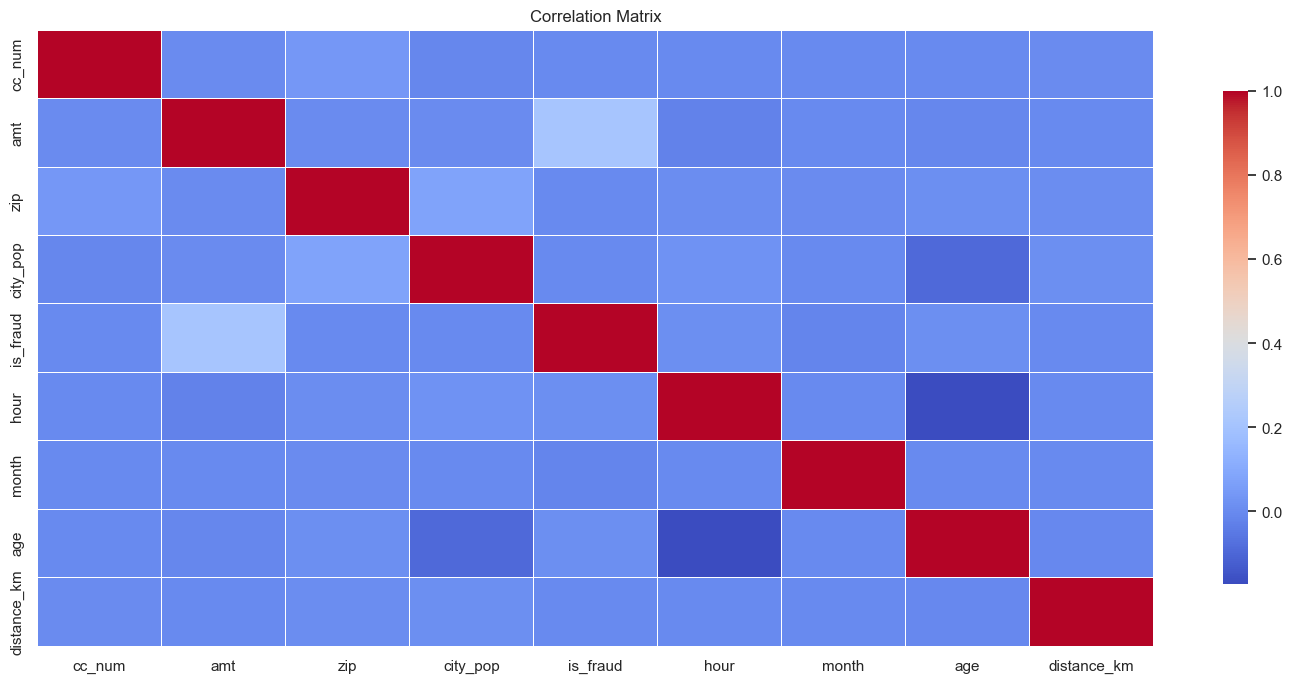

In [22]:
#Check corr between numeric values
sns.heatmap(df.select_dtypes(include='number').corr(),
            annot=None,cmap='coolwarm',fmt='.2f',linewidths=0.5,cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix')
plt.show()

In [23]:
#We can't detect a clear corr between features
df.select_dtypes(include='number').corr()

,cc_num,amt,zip,city_pop,is_fraud,hour,month,age,distance_km
cc_num,1.000000,0.001826,0.041504,-0.009118,-0.001125,-0.000902,-0.000188,-0.000131,0.003082
amt,0.001826,1.000000,0.001979,0.004921,0.209308,-0.024891,-0.002593,-0.010695,-0.000538
zip,0.041504,0.001979,1.000000,0.077601,-0.002190,0.005947,0.001160,0.010359,0.006750
city_pop,-0.009118,0.004921,0.077601,1.000000,0.000325,0.019949,-0.000510,-0.090889,0.010989
is_fraud,-0.001125,0.209308,-0.002190,0.000325,1.000000,0.013196,-0.016417,0.010927,0.000359
hour,-0.000902,-0.024891,0.005947,0.019949,0.013196,1.000000,-0.000986,-0.173014,0.000391
month,-0.000188,-0.002593,0.001160,-0.000510,-0.016417,-0.000986,1.000000,0.000060,-0.000067
age,-0.000131,-0.010695,0.010359,-0.090889,0.010927,-0.173014,0.000060,1.000000,-0.004155
distance_km,0.003082,-0.000538,0.006750,0.010989,0.000359,0.000391,-0.000067,-0.004155,1.000000


##### Get in depth in data

In [24]:
#Function to visualize determined data
def bar_plot(col):
    def top_frauds(col):
        return pd.DataFrame(df.loc[df['is_fraud']==1,[col]].value_counts()).reset_index().head(10)
    ax=sns.barplot(data=top_frauds(col),x=col,y='count',palette='bone')
    ax.bar_label(ax.containers[0])
    plt.title(f'Top 10 Frauds | {col}',fontsize=16,fontweight='bold')
    plt.xticks(rotation=45,fontweight='bold')

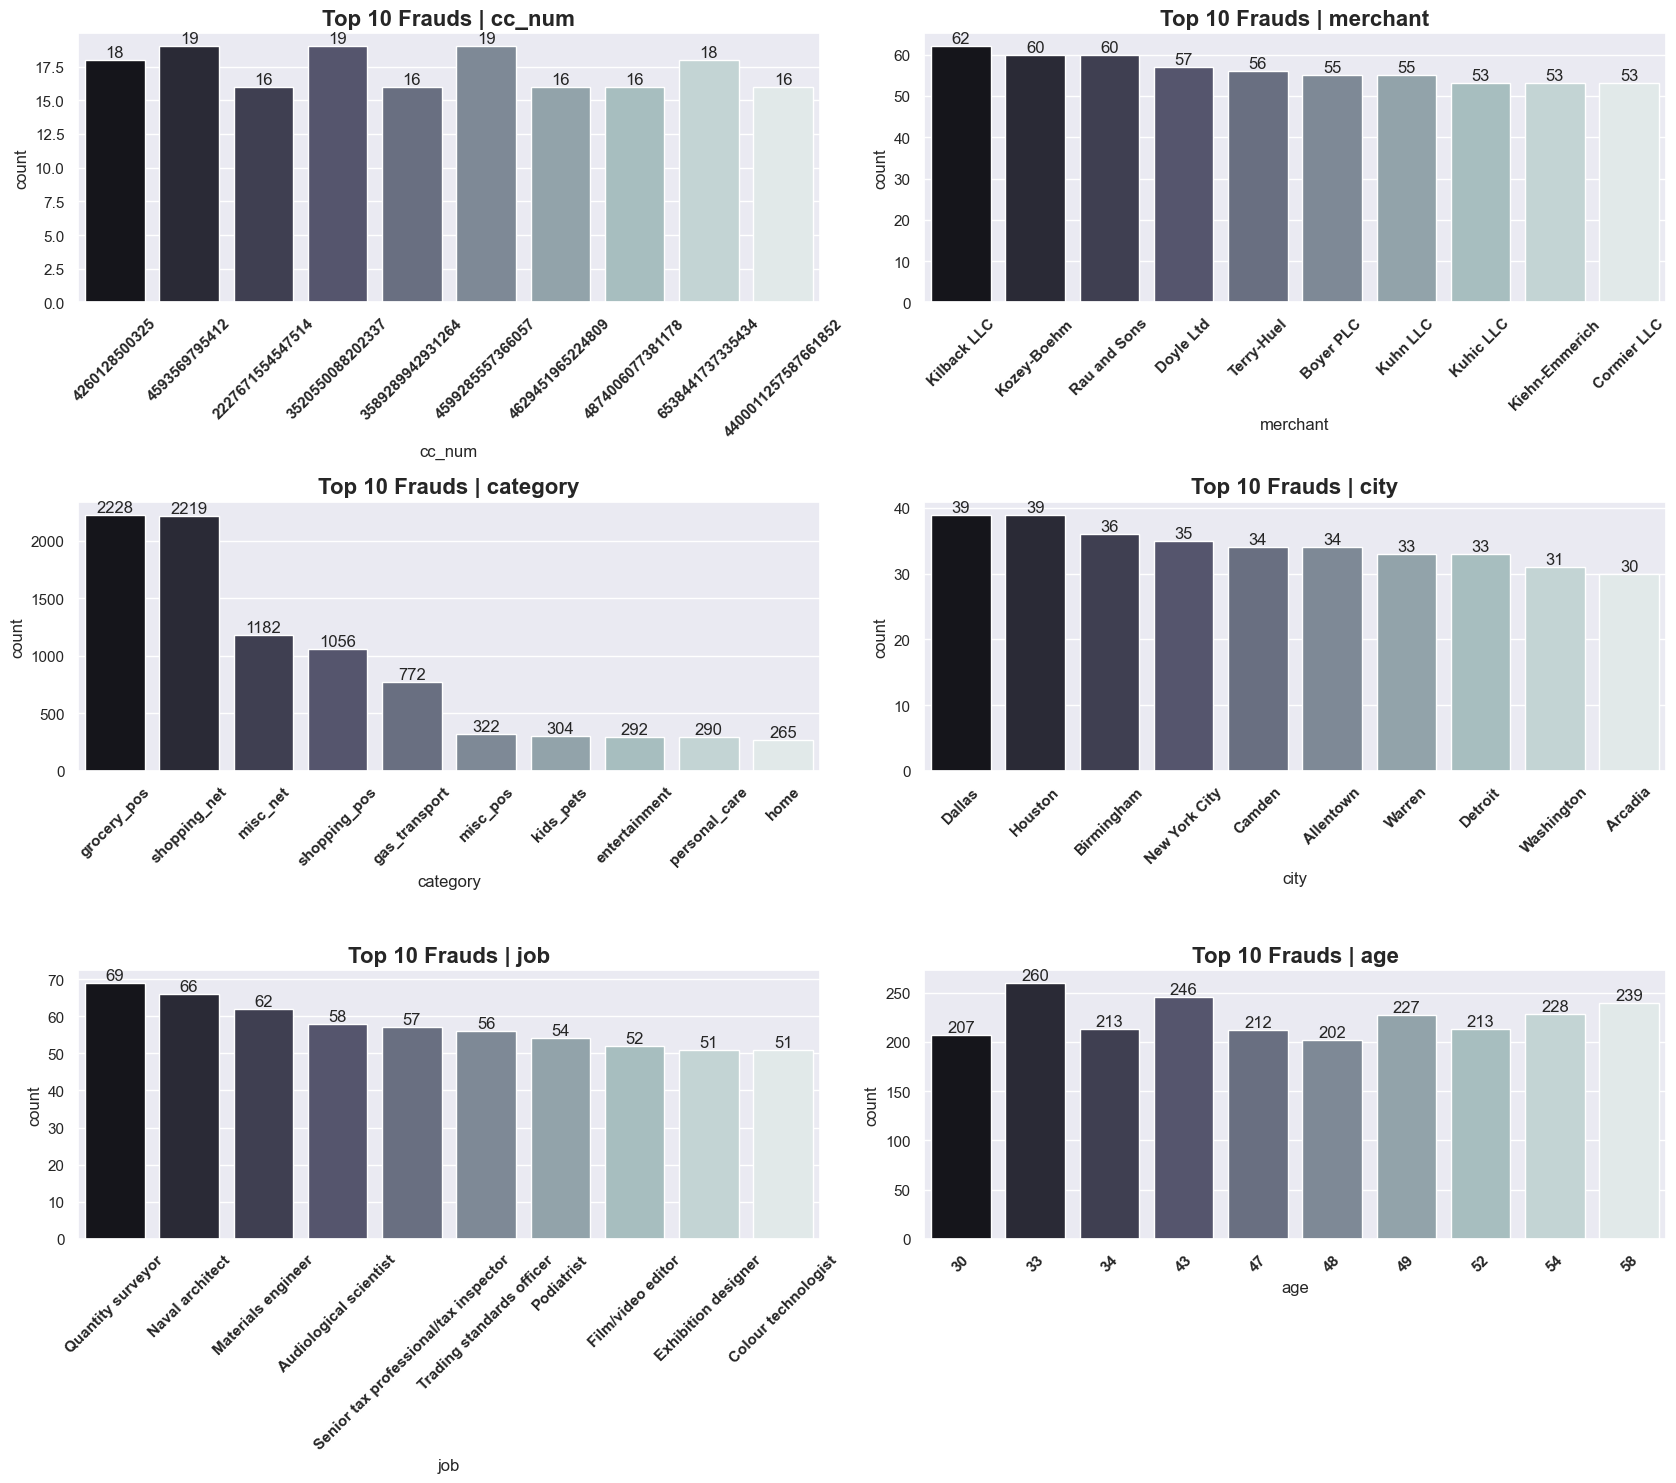

In [25]:
plt.figure(figsize=(17,15))
for idx,val in enumerate(['cc_num','merchant','category','city','job','age']):
    plt.subplot(3,2,idx+1)
    bar_plot(val)
plt.tight_layout()

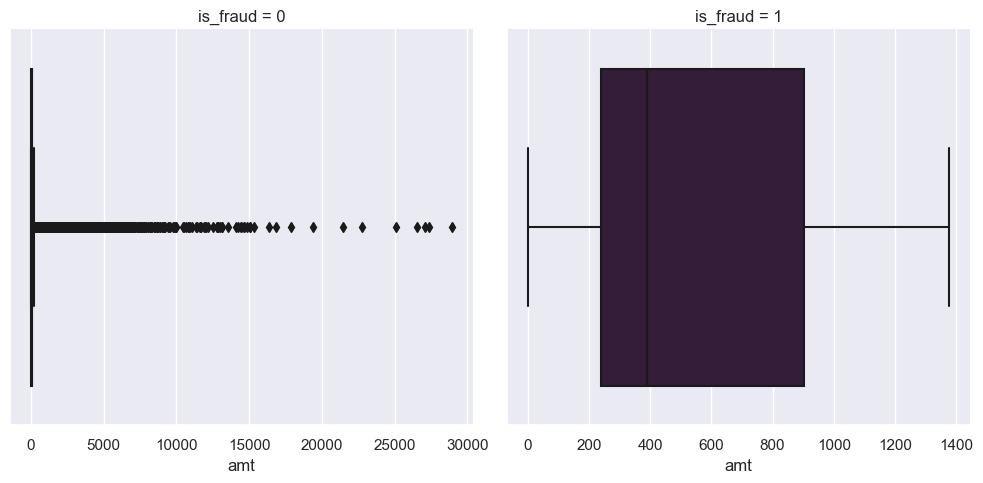

In [26]:
#Amount
sns.catplot(data=df,x='amt',col='is_fraud',kind='box',sharex=False)

In [27]:
#We detect a huge number of outliers in the amounts of genuine transaction
#We will handle that in the scaling process since we can't remove them
#Because they represent real data

In [28]:
def pie_bar_plot(col):
    print(df[col].value_counts())
    sns.set_palette('viridis')
    fig,axs=plt.subplots(1,2)
    axs[0].pie(df[col].value_counts().values.tolist(),autopct='%.2f%%',textprops={'fontsize':25},explode=[0,0.05],shadow=True)
    sns.countplot(data=df,x=col,ax=axs[1])
    fig.legend(labels=df[col].value_counts().index.tolist(),loc='upper left',fontsize=20)
    fig.tight_layout()
    fig.show()

gender

F    1014749

M     837645

Name: count, dtype: int64


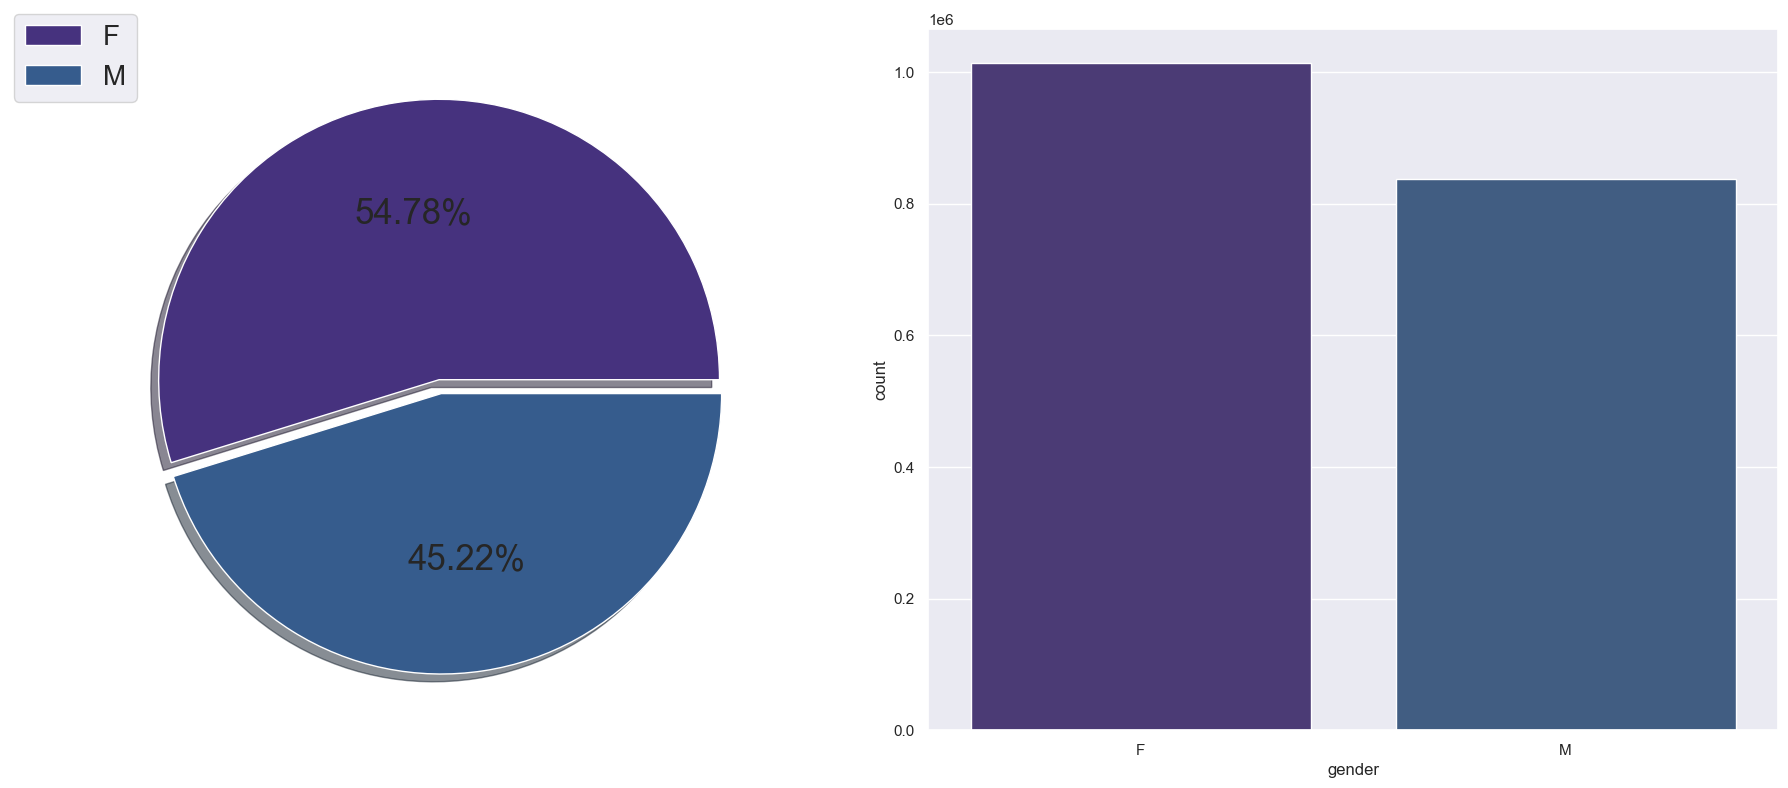

In [29]:
#Gender
pie_bar_plot('gender')

is_fraud

0    1842743

1       9651

Name: count, dtype: int64


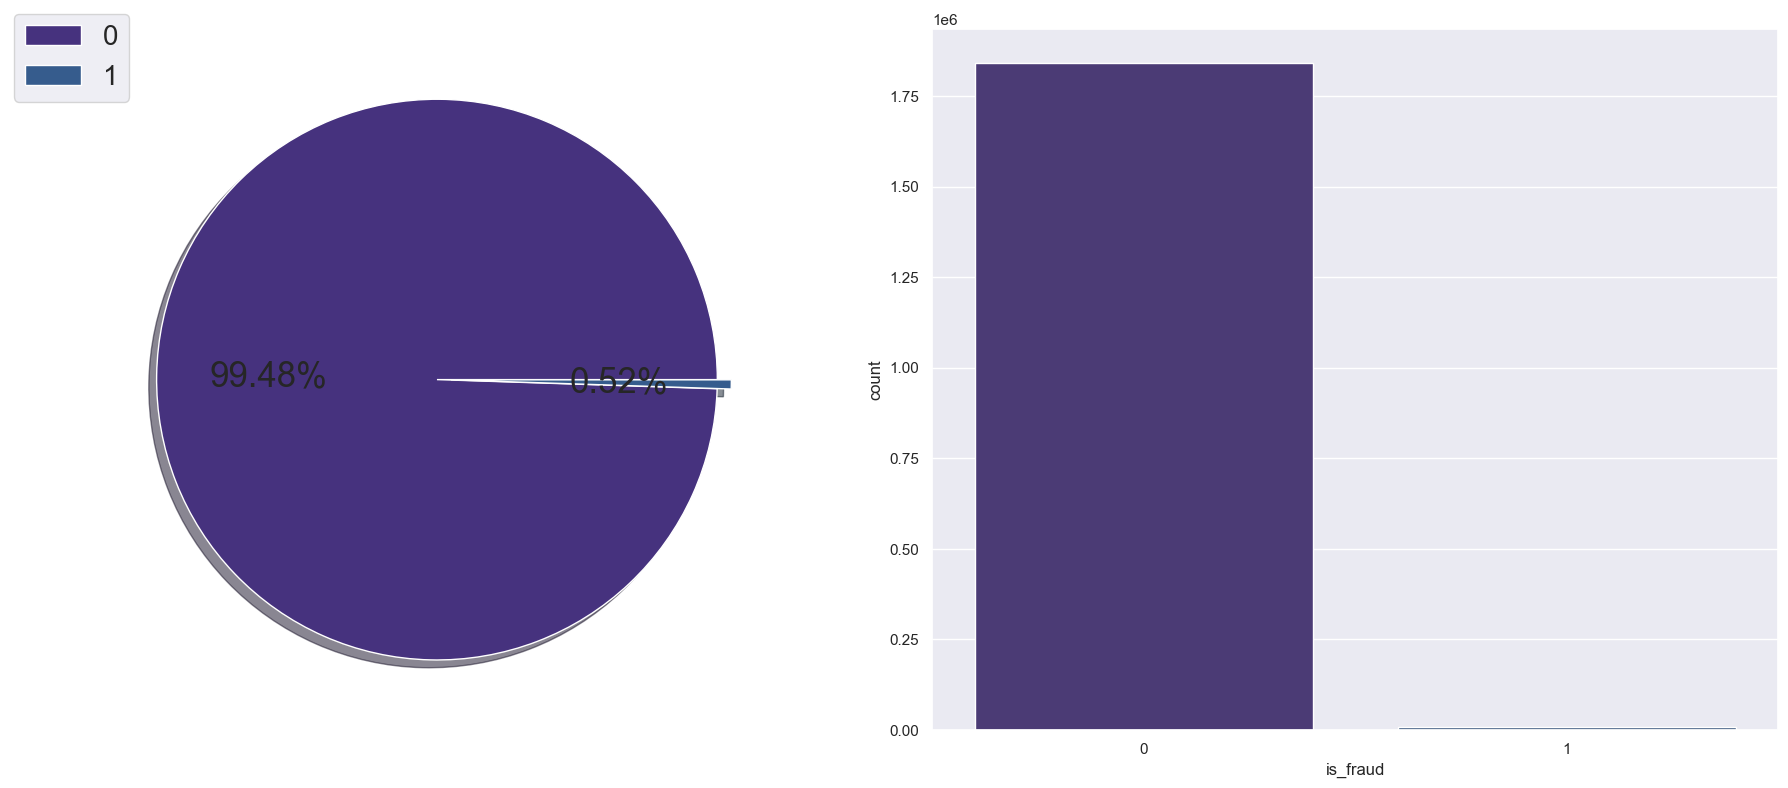

In [30]:
#Frauds
pie_bar_plot('is_fraud')

In [31]:
#We discover that is_fraud column is imbalanced.
#So will fix that later

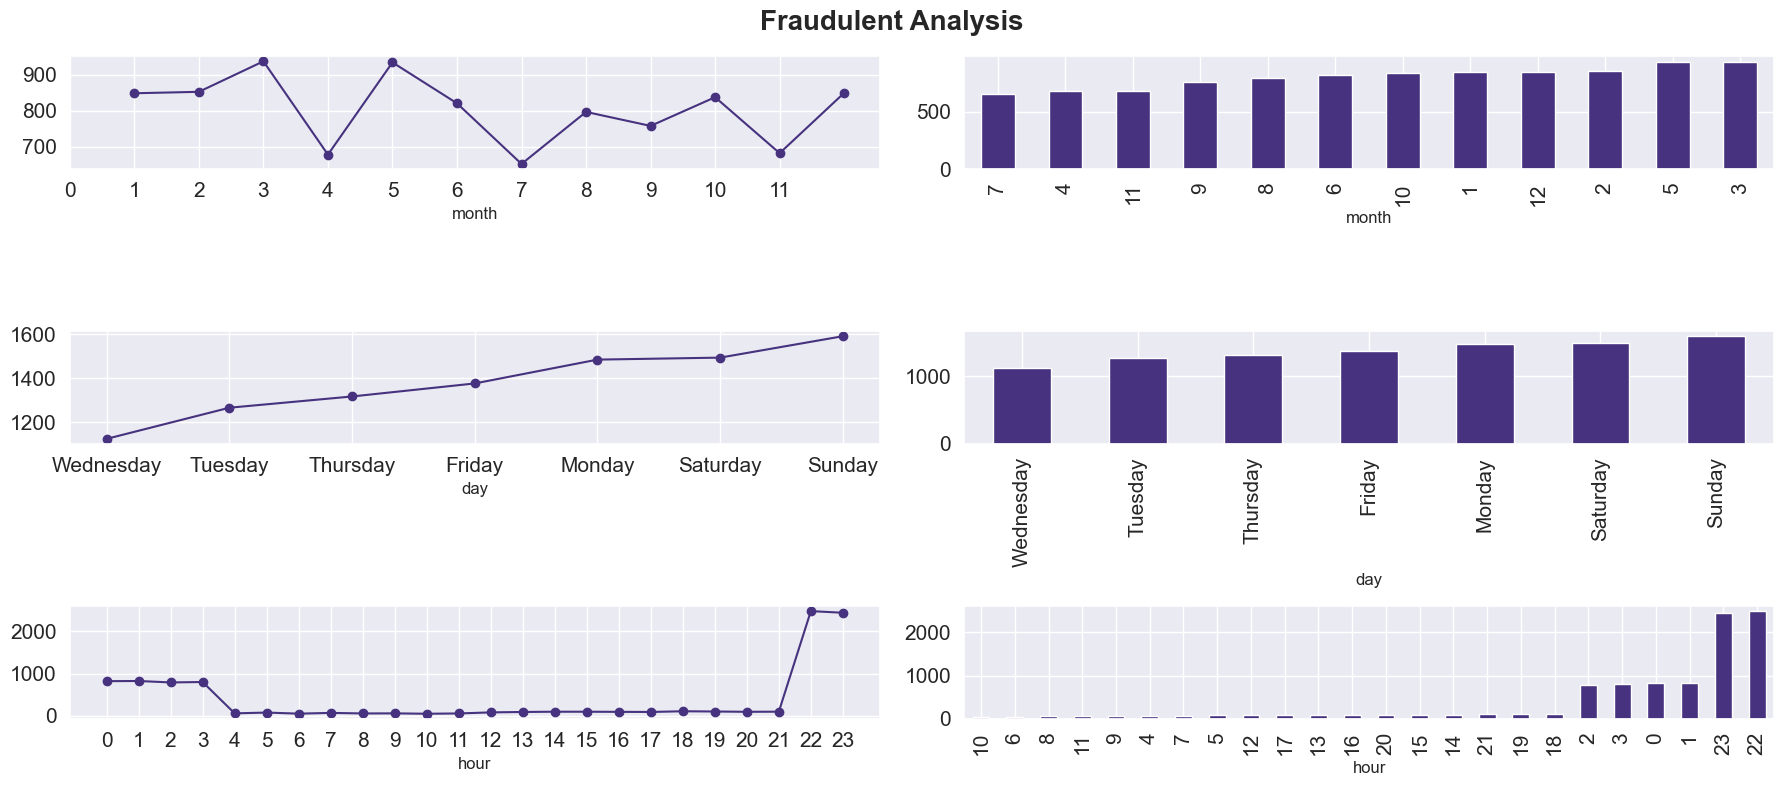

In [32]:
#What is the most month|day|hour frauds occur?
fig,axs = plt.subplots(3,2)
#Month
df.loc[df['is_fraud']==1,'month'].value_counts().sort_index().plot(kind='line',ax=axs[0,0],marker='o',fontsize=15)
axs[0,0].set_xticks(range(0,12))
df.loc[df['is_fraud']==1,'month'].value_counts(ascending=True).plot(kind='bar',ax=axs[0,1],fontsize=15)
fig.suptitle('Fraudulent Analysis', fontsize=18, fontweight='bold')
##Day
df.loc[df['is_fraud']==1,'day'].value_counts(ascending=True).plot(kind='line',ax=axs[1,0],marker='o',fontsize=15)
df.loc[df['is_fraud']==1,'day'].value_counts(ascending=True).plot(kind='bar',ax=axs[1,1],fontsize=15)
#Hour 
df.loc[df['is_fraud']==1,'hour'].value_counts().sort_index().plot(kind='line',ax=axs[2,0],marker='o',fontsize=15)
axs[2,0].set_xticks(range(0,24))
df.loc[df['is_fraud']==1,'hour'].value_counts(ascending=True).plot(kind='bar',ax=axs[2,1],fontsize=15)
fig.suptitle('Fraudulent Analysis', fontsize=20, fontweight='bold')
plt.tight_layout()

#### We conclude that most fraud transactions occurs: 
- On March
- On Sunday
- At 10 PM

In [33]:
df.loc[df['is_fraud']==1,['gender']].value_counts()
#Males and females exposed to fraud equally (approximately)

gender
F         4899
M         4752
Name: count, dtype: int64

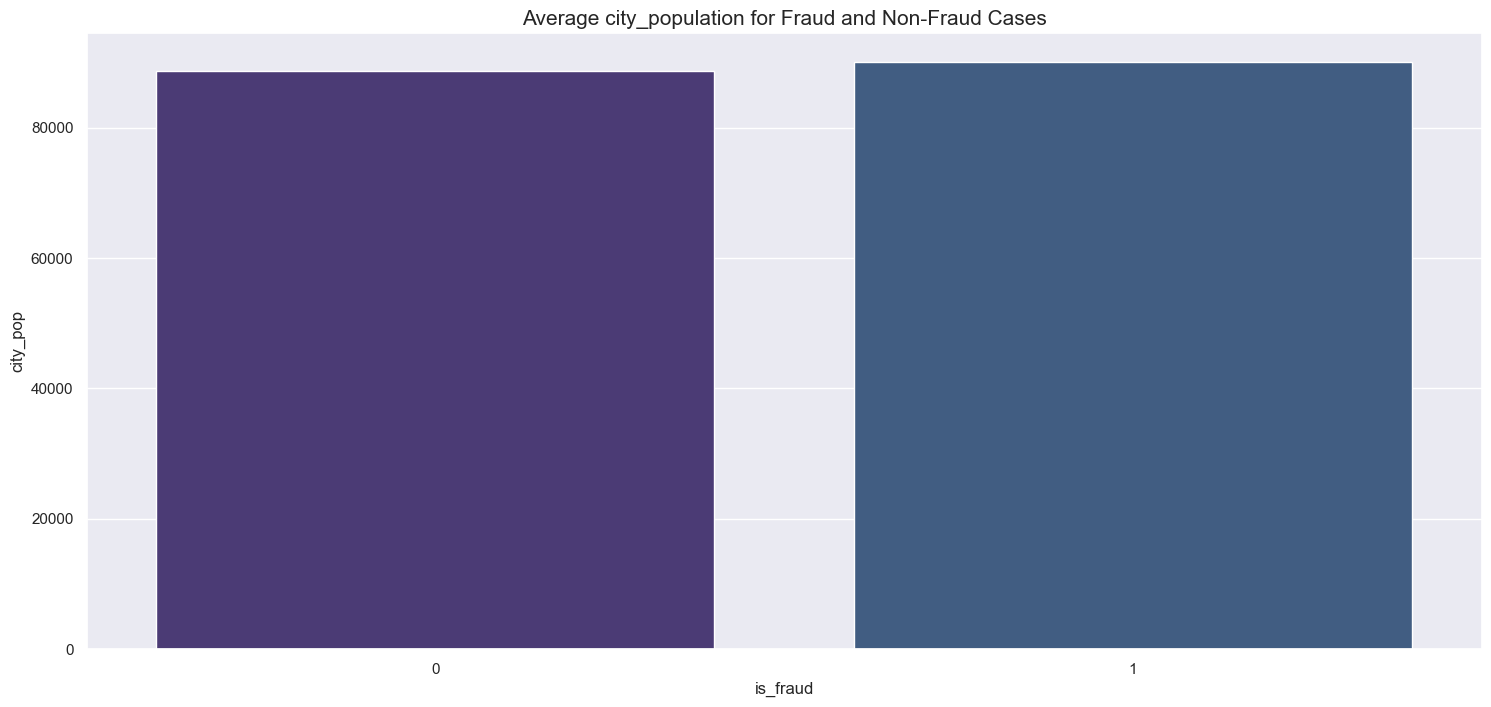

T-test: t-statistic = 0.443, p-value = 0.658, p-value<0.05? False


In [34]:
sns.barplot(data=df,x='is_fraud', y='city_pop', ci=None)
plt.title('Average city_population for Fraud and Non-Fraud Cases',fontsize=15)
plt.show()

fraud_population = df[df['is_fraud'] == 1]['city_pop']
non_fraud_population = df[df['is_fraud'] == 0]['city_pop']
t_stat, p_value = ttest_ind(fraud_population, non_fraud_population)
print(f'T-test: t-statistic = {round(t_stat,3)}, p-value = {round(p_value,3)}, p-value<0.05? {p_value<0.05}')

In [35]:
#Since we accept the null hypothesis,we conclude that there is no significant difference between means,
#We conclude also that city_population does not help us on the target(is_fraud), so we will drop it

# Further Preprocessing

In [36]:
df.head(3)

,trans_date_trans_time,cc_num,merchant,category,amt,gender,city,zip,city_pop,job,is_fraud,split,hour,day,month,age,distance_km
0,2019-01-01 00:00:18,2703186189652095,"Rippin, Kub and Mann",misc_net,4.97,F,Moravian Falls,28654,3495,"Psychologist, counselling",0,train,0,Tuesday,1,31,78.60
1,2019-01-01 00:00:44,630423337322,"Heller, Gutmann and Zieme",grocery_pos,107.23,F,Orient,99160,149,Special educational needs teacher,0,train,0,Tuesday,1,41,30.21
2,2019-01-01 00:00:51,38859492057661,Lind-Buckridge,entertainment,220.11,M,Malad City,83252,4154,Nature conservation officer,0,train,0,Tuesday,1,57,108.21


In [37]:
#Convert gender to binary classification
df = pd.get_dummies(df,columns=['gender'],drop_first=True)

In [38]:
#We will get the time between transactions for each card
#Time=0 for every first transaction and time will be represented in hours.
df.sort_values(['cc_num', 'trans_date_trans_time'],inplace=True)
df['hours_diff_bet_trans']=((df.groupby('cc_num')[['trans_date_trans_time']].diff())/np.timedelta64(1,'h'))

In [39]:
df.loc[df['hours_diff_bet_trans'].isna(),'hours_diff_bet_trans'] = 0
df['hours_diff_bet_trans'] = df['hours_diff_bet_trans'].astype(int)

                T          p-val

T-test  27.266899  7.200860e-158


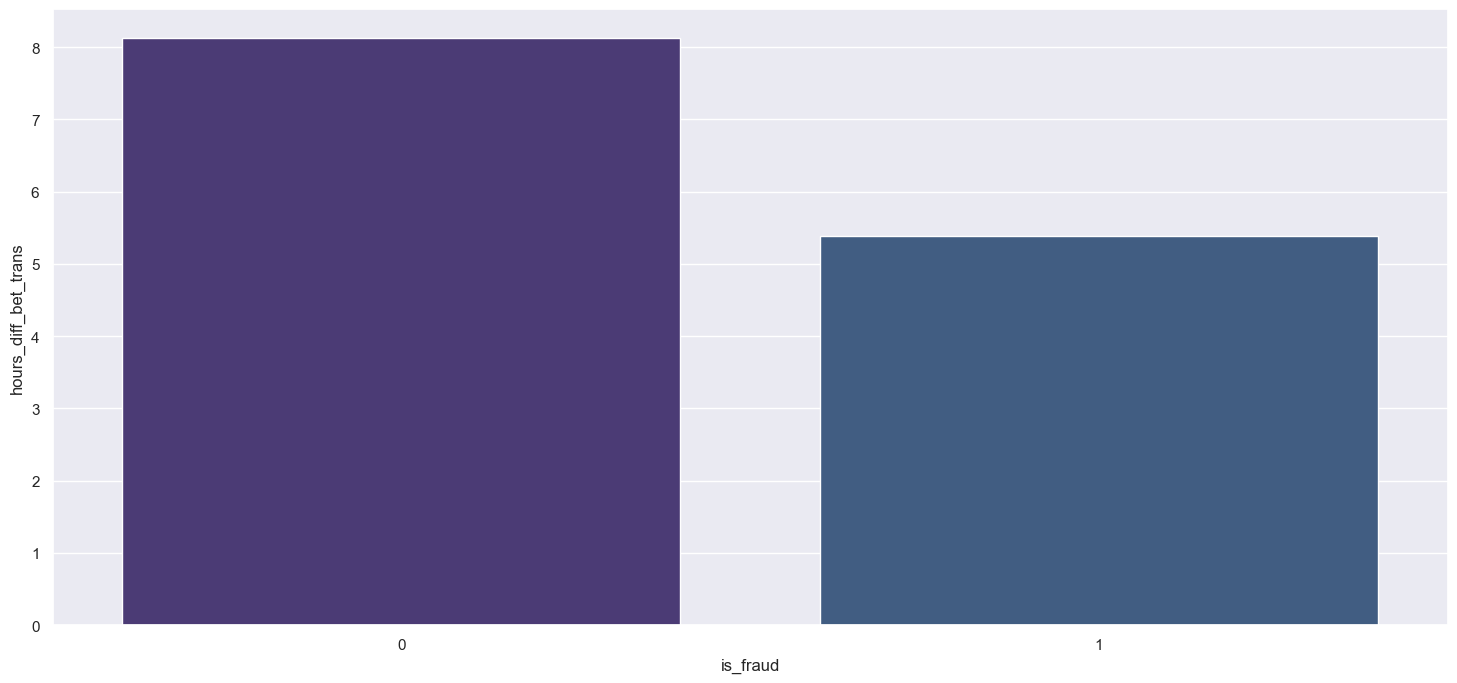

In [40]:
# x_0=df.groupby('is_fraud')['hours_diff_bet_trans'].mean().values[0]
# x_1=df.groupby('is_fraud')['hours_diff_bet_trans'].mean().values[1]
# std_0=df.groupby('is_fraud')['hours_diff_bet_trans'].std().values[0]
# std_1=df.groupby('is_fraud')['hours_diff_bet_trans'].std().values[1]
# n_0=df.groupby('is_fraud')['hours_diff_bet_trans'].count().values[0]
# n_1=df.groupby('is_fraud')['hours_diff_bet_trans'].count().values[1]
# numerator = x_0 - x_1
# domin = np.sqrt(std_0**2/n_0 + std_1**2/n_1)
# t_stat=numerator/domin
# p_val = 2*(1-t.cdf(abs(t_stat),df=n_0+n_1-2))
# print(t_stat,p_val)
#----------------------
#The power of pingouin library!
print(pingouin.ttest(df[df['is_fraud'] == 0]['hours_diff_bet_trans'],
              df[df['is_fraud'] == 1]['hours_diff_bet_trans'],
              alternative='two-sided')[['T','p-val']])
sns.barplot(data=df,x='is_fraud',y='hours_diff_bet_trans',ci=None)
plt.show()

In [41]:
#Since p-val < 0.05,we reject the null hypothesis.
#The mean of hours is significantly different between frauds and non-frauds transactions

In [42]:
#Make day feature numerical
df['day'] = df['trans_date_trans_time'].dt.weekday

In [43]:
#Handling and extracting features from cc_num
freq = df.groupby('cc_num').size()
df['cc_freq'] = df['cc_num'].apply(lambda x : freq[x])
df[['cc_num','cc_freq']].head()

,cc_num,cc_freq
1017,60416207185,2196
2724,60416207185,2196
2726,60416207185,2196
2882,60416207185,2196
2907,60416207185,2196


In [44]:
#We got freq for each cc_num
def hist_show(col):
    fig,axs = plt.subplots(1,2,sharex=True)
    for i in [0,1]:
        sns.histplot(df[df["is_fraud"]==i][col], bins=6,ax=axs[i])

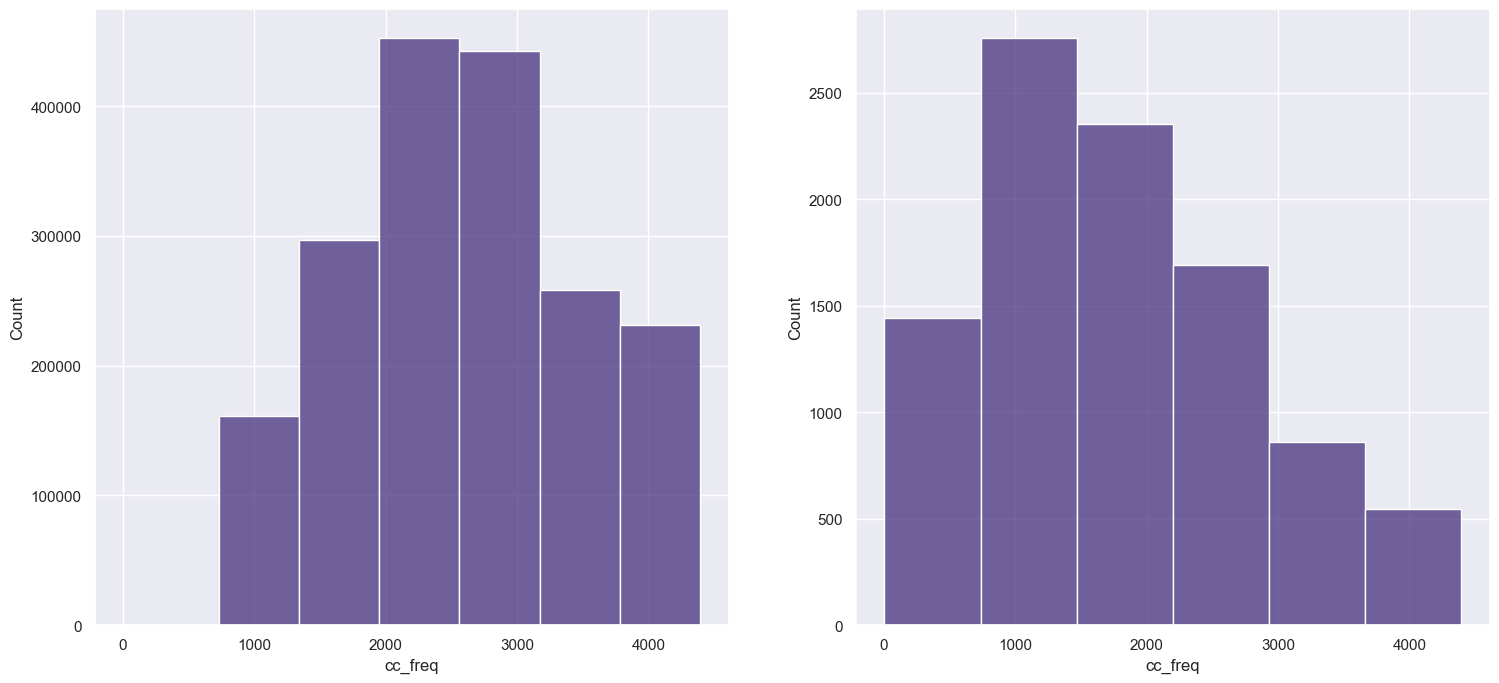

In [45]:
hist_show('cc_freq')

In [46]:
def class_det(x):
    for idx,val in enumerate(list(range(800,5000,800))):
        if x < val:
            return idx+1

In [47]:
df['cc_freq_class'] = df['cc_freq'].apply(class_det)
print(df['cc_freq_class'].unique())

[3 1 2 4 5 6]


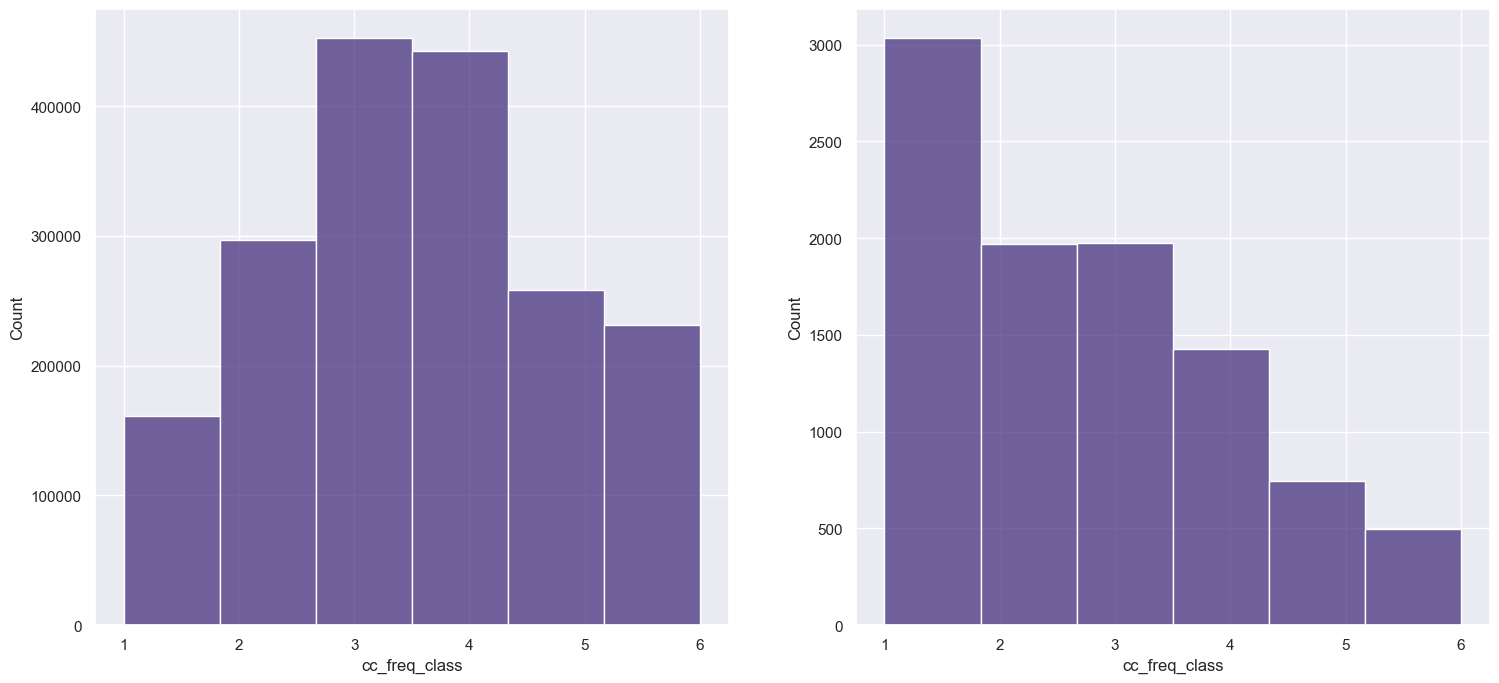

In [48]:
hist_show('cc_freq_class')

#### Now clearly frauds occurs more in credit cards with less use (new ones) and for genuine transactions, it follows a normal distribution.

In [49]:
#Drop unecessary columns
df.drop(columns=['cc_num','trans_date_trans_time','city_pop'],inplace=True)

In [50]:
df.columns

Index(['merchant', 'category', 'amt', 'city', 'zip', 'job', 'is_fraud',
       'split', 'hour', 'day', 'month', 'age', 'distance_km', 'gender_M',
       'hours_diff_bet_trans', 'cc_freq', 'cc_freq_class'],
      dtype='object')

In [51]:
#Reorder columns
df = df[['cc_freq','cc_freq_class','city','job','age','gender_M','merchant', 'category',
         'distance_km','month','day','hour','hours_diff_bet_trans','amt','is_fraud','split']]
df.head()

,cc_freq,cc_freq_class,city,job,age,gender_M,merchant,category,distance_km,month,day,hour,hours_diff_bet_trans,amt,is_fraud,split
1017,2196,3,Fort Washakie,Information systems manager,33,False,"Jones, Sawayn and Romaguera",misc_net,127.61,1,1,12,0,7.27,0,train
2724,2196,3,Fort Washakie,Information systems manager,33,False,Berge LLC,gas_transport,110.31,1,2,8,19,52.94,0,train
2726,2196,3,Fort Washakie,Information systems manager,33,False,Luettgen PLC,gas_transport,21.79,1,2,8,0,82.08,0,train
2882,2196,3,Fort Washakie,Information systems manager,33,False,Daugherty LLC,kids_pets,87.20,1,2,12,3,34.79,0,train
2907,2196,3,Fort Washakie,Information systems manager,33,False,Beier and Sons,home,74.21,1,2,13,0,27.18,0,train


In [52]:
#We will encode ('city','job','merchant', 'category') preparing for our model using WOE encoder
for col in ['city','job','merchant', 'category']:
    df[col] = WOEEncoder().fit_transform(df[col],df['is_fraud'])

In [53]:
# WOE > 0: The category is more likely associated with (fraud)
# WOE < 0: The category is more likely associated with (non-fraud)
df.head()

,cc_freq,cc_freq_class,city,job,age,gender_M,merchant,category,distance_km,month,day,hour,hours_diff_bet_trans,amt,is_fraud,split
1017,2196,3,-0.193426,0.163804,33,False,0.472059,0.925860,127.61,1,1,12,0,7.27,0,train
2724,2196,3,-0.193426,0.163804,33,False,-0.499771,-0.238221,110.31,1,2,8,19,52.94,0,train
2726,2196,3,-0.193426,0.163804,33,False,-0.132212,-0.238221,21.79,1,2,8,0,82.08,0,train
2882,2196,3,-0.193426,0.163804,33,False,-0.620062,-1.019735,87.20,1,2,12,3,34.79,0,train
2907,2196,3,-0.193426,0.163804,33,False,-1.296190,-1.238421,74.21,1,2,13,0,27.18,0,train


In [54]:
x_train = df[df['split']=='train'].drop(['split','is_fraud'],axis=1)
y_train = df[df['split']=='train']['is_fraud']
x_test = df[df['split']=='test'].drop(['split','is_fraud'],axis=1)
y_test = df[df['split']=='test']['is_fraud']

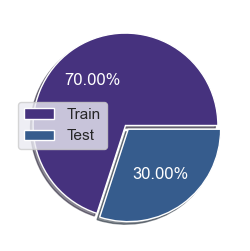

In [55]:
plt.figure(figsize=(3,3))
plt.pie([len(x_train),len(x_test)],autopct='%.2f%%'
        ,textprops={'color':'white'},explode=[0,0.05],shadow=True)
plt.legend(['Train','Test'])
plt.show()

In [56]:
#Handling outliers
x_train.select_dtypes(include='number').columns

Index(['cc_freq', 'cc_freq_class', 'city', 'job', 'age', 'merchant',
       'category', 'distance_km', 'month', 'day', 'hour',
       'hours_diff_bet_trans', 'amt'],
      dtype='object')

In [57]:
datasets={'x_train':x_train,'x_test':x_test}
cols = ['hours_diff_bet_trans', 'amt']

In [58]:
#Outliers in train data before scaling
def count_outliers(l:list):
    for col in l:
        print(f'Outliers In {col}:',len(detect_outliers(x_train,0,[col])))

In [59]:
def boxplot_outliers(ds:dict):
    plt.figure(figsize=(18,8))
    c=1
    for _,df_x in ds.items():
        for col in ['hours_diff_bet_trans', 'amt']:
            plt.subplot(2,2,c)
            df_x[col].plot(kind='box',vert=False)
            c+=1        
    plt.suptitle('Detecting Outliers In Train|Test Data',fontsize=20)
    plt.tight_layout()

Outliers In hours_diff_bet_trans: 86989

Outliers In amt: 67290


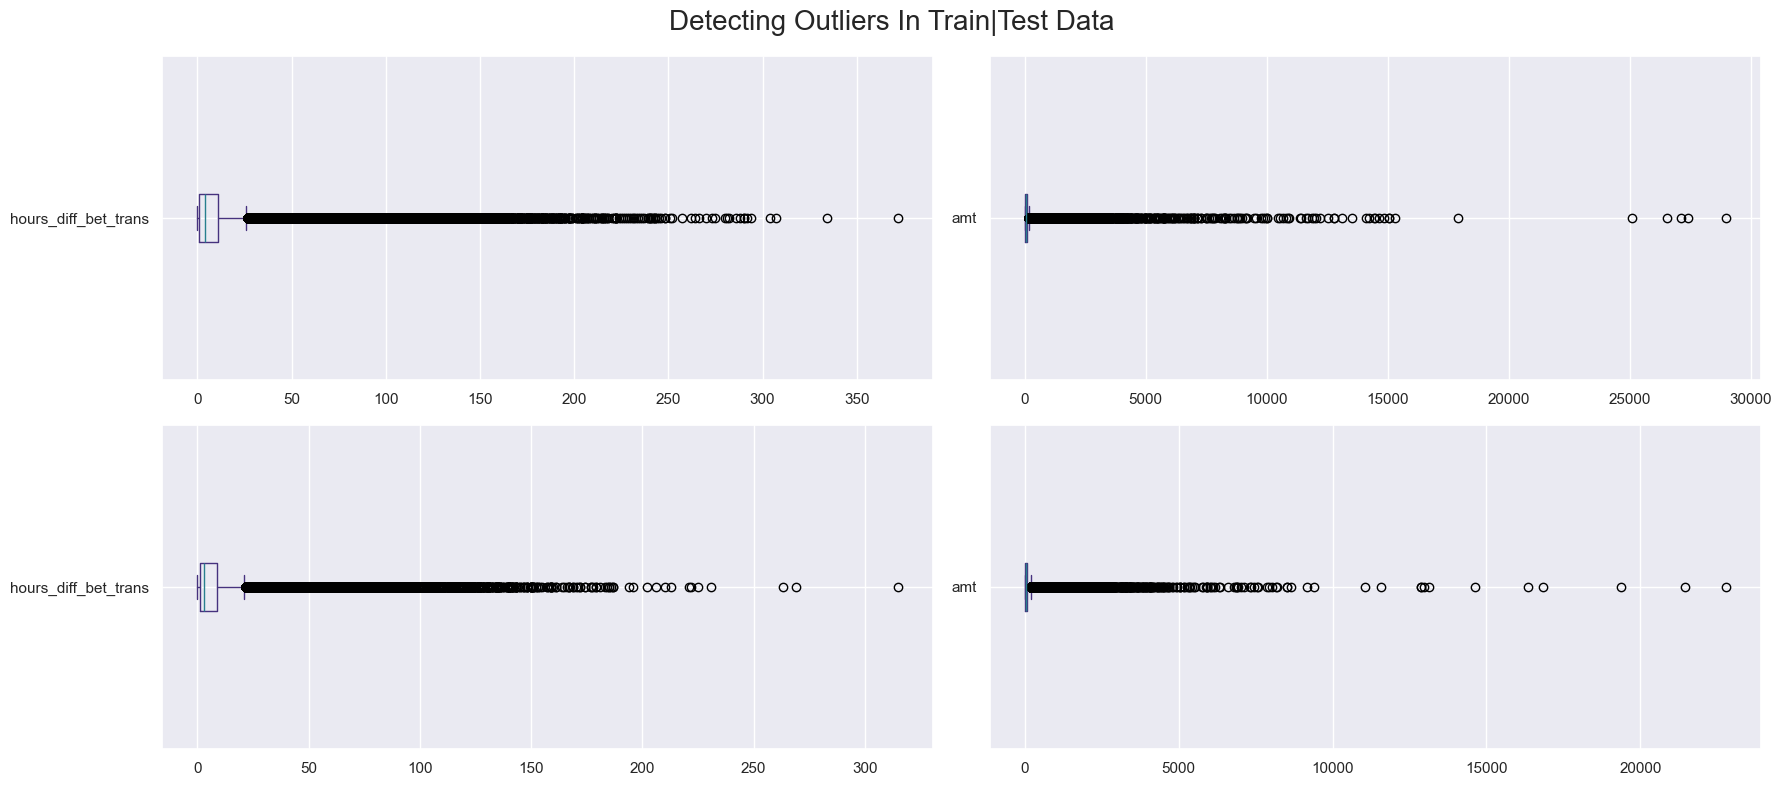

In [60]:
count_outliers(cols)
boxplot_outliers(datasets)

In [61]:
#Applying log scale
for col in cols:
    x_train[col] = np.log1p(x_train[col])
    x_test[col] = np.log1p(x_test[col])

Outliers In hours_diff_bet_trans: 222

Outliers In amt: 818


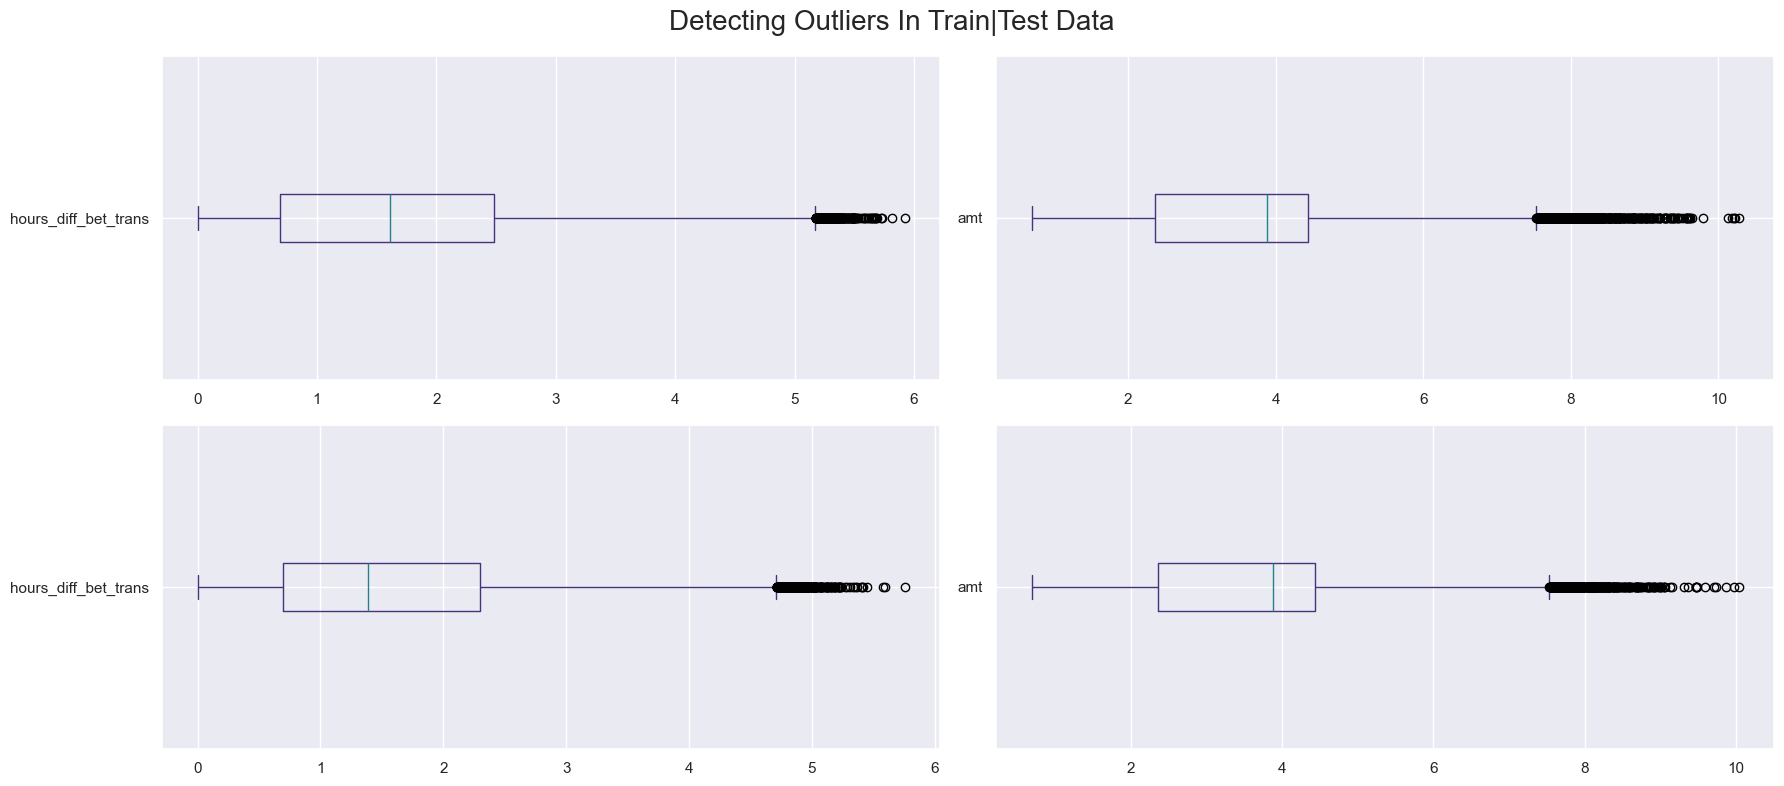

In [62]:
count_outliers(cols)
boxplot_outliers(datasets)

#### As we can see the log transformation make the distribution more symmetric and reduce the impact of extreme values(We did not removed them).Also we can deal with these data separately,But for now: log functions are commonly used to handle right-skewed distributions. After applying our model we can revert data with exp. function to recover the actual data.

In [63]:
#Note:-
#Logistic Regression often benefits from feature scaling.Since the algorithm uses the weights assigned to features during
#training, and having features on similar scales can help the optimization process converge faster.
#While Decision Trees, including Random Forest (an ensemble of decision trees), are generally not sensitive to the scale of the
#features.They make decisions based on splitting criteria and don't rely on the absolute values of the features.
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

# Model Building

#### We want to avoid false negatives as much as possible.A false negative case means that a fraud-positive transaction is assessed to genuine transaction,In this use case false positives (a genuine transaction as fraud-positive) are not as important as preventing a fraud. So our focus is about (RECALL).

In [64]:
#Let's try our model without handling the imbalance data of fraud feature

In [65]:
evl_models = {'Logistic Regression':LogisticRegression(random_state=10),
          'Decision Tree':DecisionTreeClassifier(random_state=10),
          'Random Forest':RandomForestClassifier(random_state=10)}

In [66]:
def evl_model(xtrain,ytrain,xtest,ytest):
    sns.set(rc={'figure.figsize':(18,6)})
    i=0
    for name,model in evl_models.items():
        fig,axs=plt.subplots(1,2)
        print('Model : '+name)
        print('_'*30)
        start=time()
        model.fit(xtrain,ytrain)
        y_pred = model.predict(xtest)
        end=time()
        #Confusion Matrix
        cm = confusion_matrix(ytest,y_pred,labels=model.classes_)
        cmd = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
        cmd.plot(colorbar=False,ax=axs[i])
        axs[i].grid(False)
        #AUC-ROC Curve
        y_proba = model.predict_proba(xtest)
        fpr, tpr, _ = roc_curve(ytest, y_proba[:, 1])
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=axs[i+1])
        axs[i+1].plot([0, 1], [0, 1], color = 'g')
        plt.tight_layout()
        plt.show()
        #We focus on recall=TP/TP+FN
        #such that it's the score that model predict(non-fraud) while it's fraud.
        print('Recall Score: ',recall_score(ytest,y_pred))
        print('Precision: ',precision_score(ytest,y_pred))
        print('F1-Score: ',f1_score(ytest,y_pred))
        print('Accuracy Score: ',accuracy_score(ytest,y_pred))
        print('AUC Score: ',roc_auc_score(ytest,y_proba[:,1]))
        print('Running Time : ',round((end-start)/60.0,2),'Mins')
        print('*'*30)

Model : Logistic Regression

______________________________


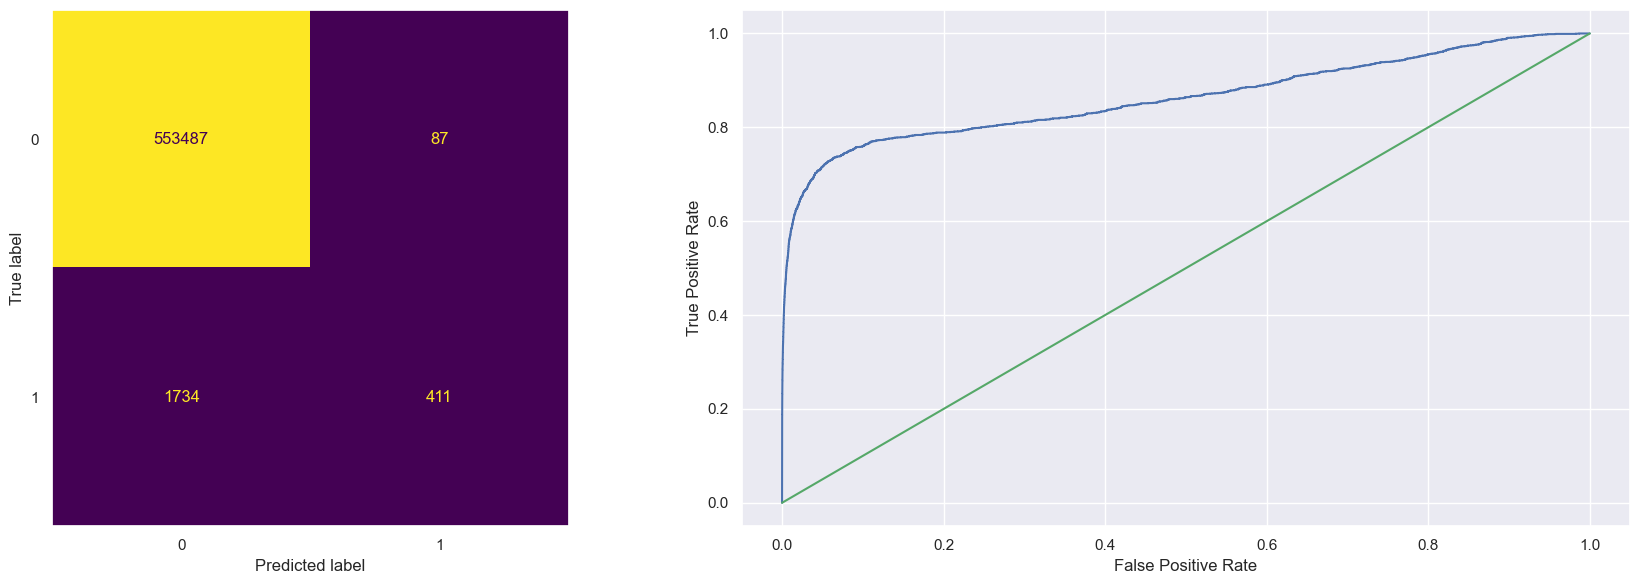

Recall Score:  0.1916083916083916

Precision:  0.8253012048192772

F1-Score:  0.3110102156640182

Accuracy Score:  0.9967231640451379

AUC Score:  0.8631322009132382

Running Time :  0.08 Mins

******************************

Model : Decision Tree

______________________________


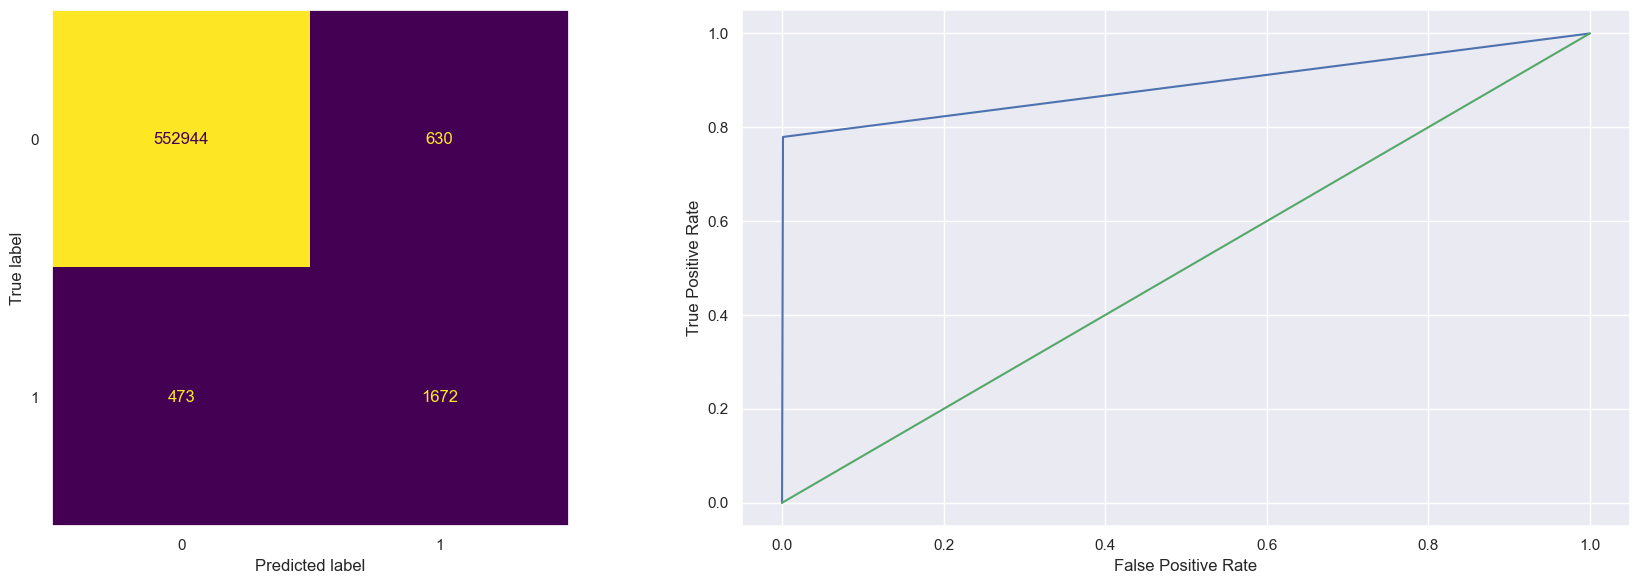

Recall Score:  0.7794871794871795

Precision:  0.7263249348392702

F1-Score:  0.7519676186192938

Accuracy Score:  0.9980151839328869

AUC Score:  0.8891745601287595

Running Time :  0.28 Mins

******************************

Model : Random Forest

______________________________


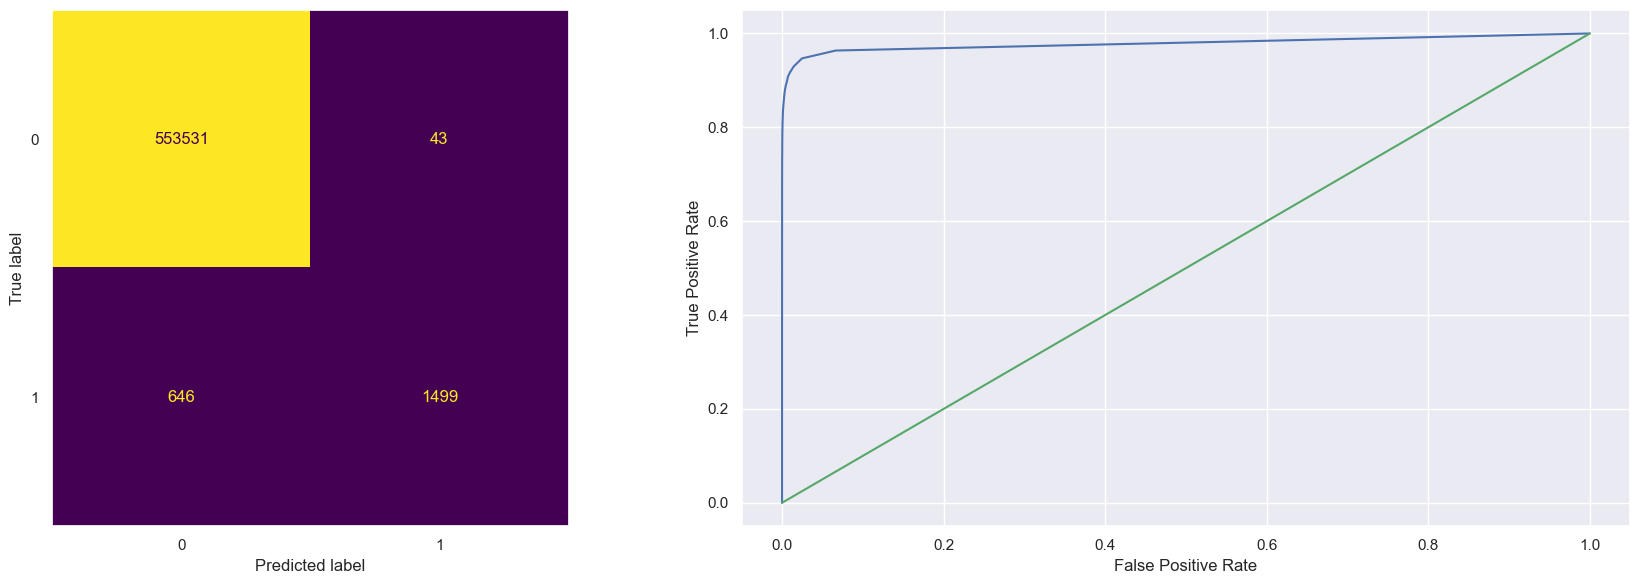

Recall Score:  0.6988344988344989

Precision:  0.9721141374837873

F1-Score:  0.8131272036886358

Accuracy Score:  0.9987601647595278

AUC Score:  0.9789703059726579

Running Time :  7.84 Mins

******************************


In [67]:
evl_model(x_train,y_train,x_test,y_test)

**Conclusions (From Imbalanced Data)**
- Logistic Regression : Gives a very weak recall accuracy 
- Decision Tree : Gives the highest recall accuracy but has a low precision
- Random Forest : Gives high recall accuracy and high precision
- Note: Our focus is not on the total model accuracy (Confusion-Matrix Accuracy) TP+TN/TP+TN+FP+FN,Since we focus on the best accuracy for the model to predict the real fraud transaction and don't predict non-fraud and we detect it from the (True Positive Rate 'Recall') 

In [69]:
#Let's apply SMOTE over sampling to make balance between fraud and non-fraud data and see if there is a significant different
#Between the accuracies or not
smote = SMOTE()
x_train,y_train = smote.fit_resample(x_train,y_train)

<Axes: ylabel='count'>

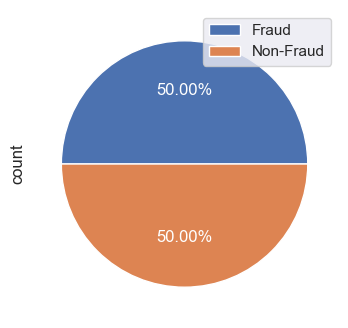

In [70]:
y_train.value_counts().plot(kind='pie',figsize=(4,4),autopct='%.2f%%',textprops={'color':'white'},labels=['Fraud','Non-Fraud'],legend=True)

Model : Logistic Regression

______________________________


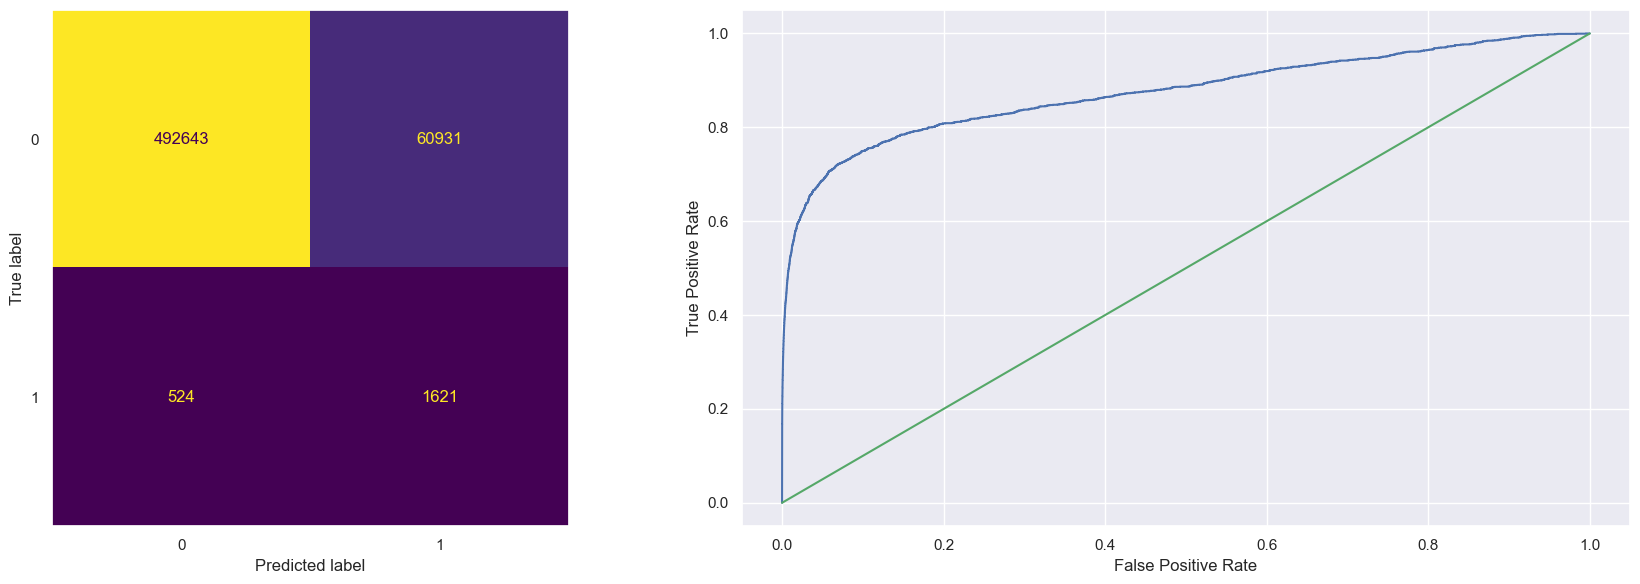

Recall Score:  0.7557109557109557

Precision:  0.025914439186596753

F1-Score:  0.05011051517071889

Accuracy Score:  0.8894135345381389

AUC Score:  0.8747800676431717

Running Time :  0.14 Mins

******************************

Model : Decision Tree

______________________________


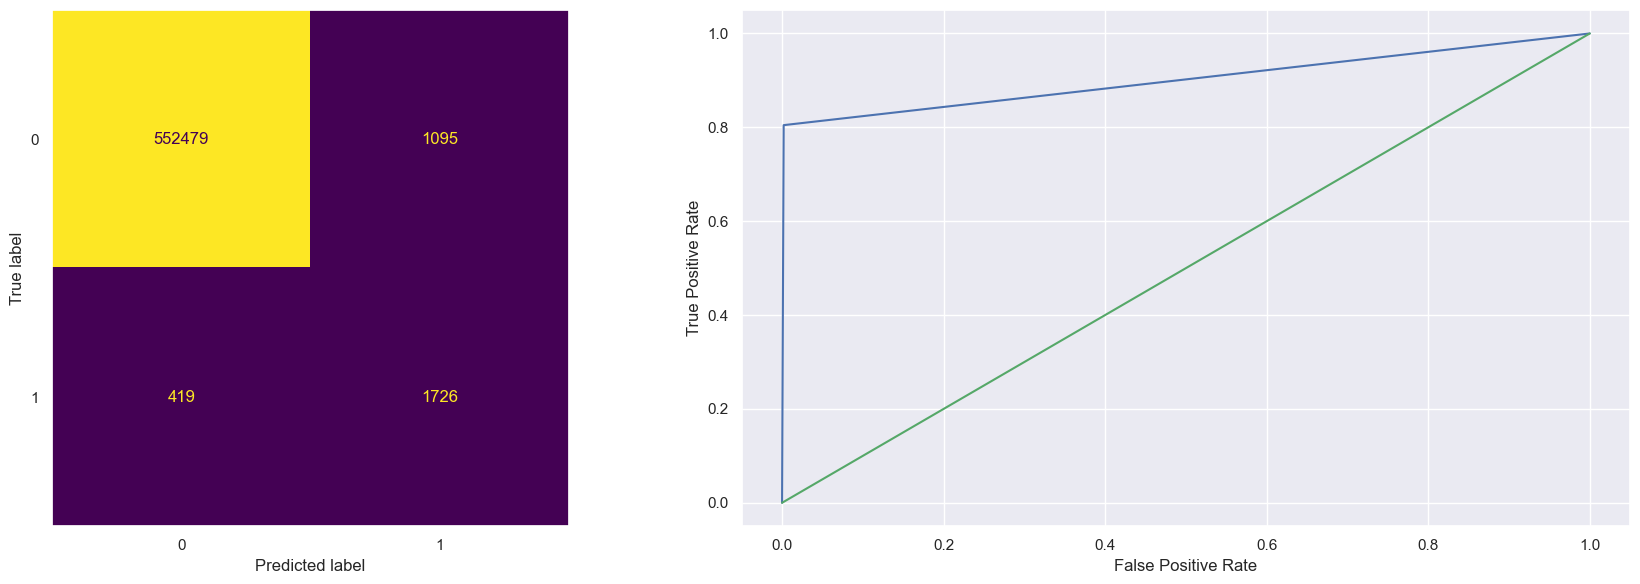

Recall Score:  0.8046620046620047

Precision:  0.6118397731300957

F1-Score:  0.6951268626661298

Accuracy Score:  0.9972756015180334

AUC Score:  0.9013419746671308

Running Time :  1.35 Mins

******************************

Model : Random Forest

______________________________


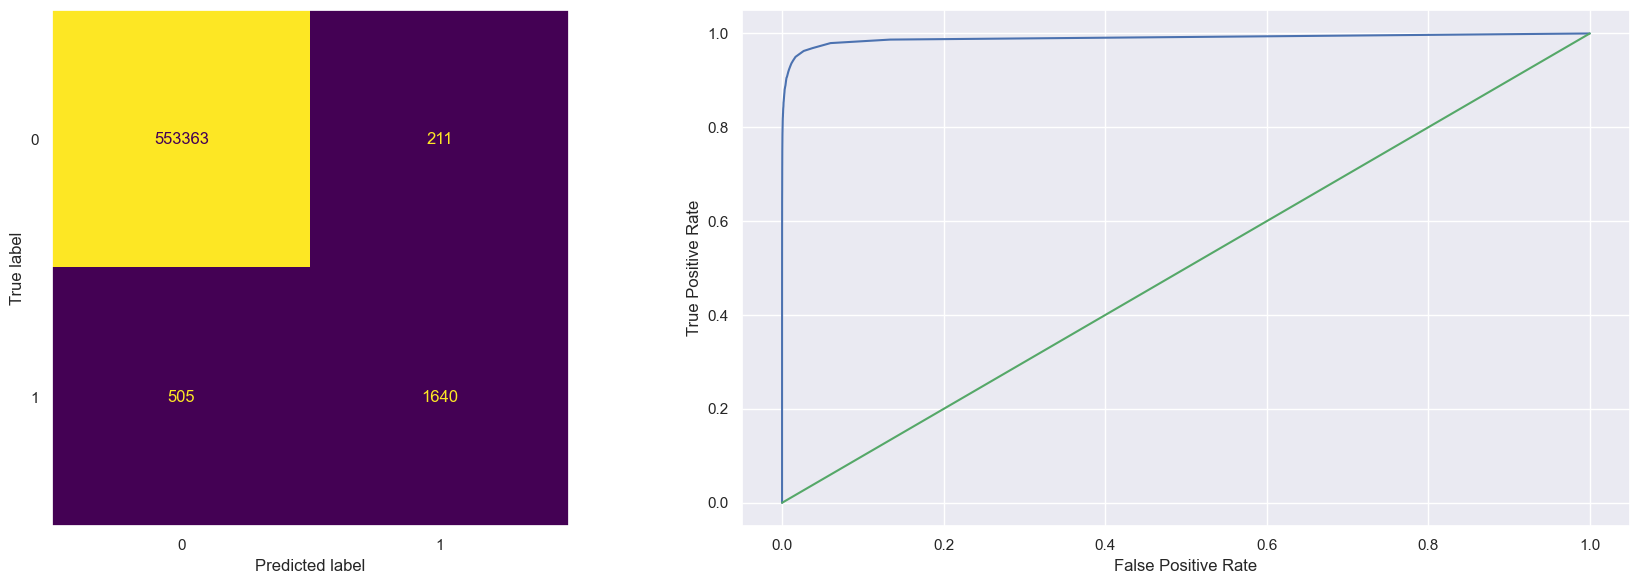

Recall Score:  0.7645687645687645

Precision:  0.8860075634792004

F1-Score:  0.8208208208208209

Accuracy Score:  0.9987115790534424

AUC Score:  0.9901384133851698

Running Time :  30.77 Mins

******************************


In [71]:
evl_model(x_train,y_train,x_test,y_test)

## Model Evaluation Considerations

### Recall (Sensitivity):

- High Recall is crucial in fraud detection to minimize the number of false negatives (missed fraud cases).
- A higher Recall indicates better sensitivity to detecting fraudulent transactions.

### Precision:

- Precision is important to minimize false positives.
- In fraud detection, a false positive might lead to inconveniencing legitimate customers.
- Balancing precision and recall is essential.

### F1-Score:

- F1-Score provides a balance between precision and recall.
- A higher F1-Score indicates a better balance between minimizing false positives and false negatives.

### Accuracy:

- While high accuracy is generally desirable, in imbalanced datasets (where fraud cases are rare), it might not be the most informative metric.
- A model could achieve high accuracy by predicting the majority class.

### AUC Score:

- AUC (Area Under the ROC Curve) provides a summary measure across various classification thresholds.
- A higher AUC indicates better overall model performance.

## Recommendation

- **RandomForest** appears to perform well across multiple metrics regardless it takes the higher time complexity, it provides a good balance between recall, precision, and accuracy.
- **DecisionTree** appears to perform well across recall , if we consider to minimize the number of false negatives (missed fraud cases) it will be the best solution, but it fails to make a good predictions on non-fraud transactions that might lead to inconveniencing legitimate customers
- **LogisticRegression** appears to perform well across recall, but gives a bad precision and accuracy so it's out of scope for our project